In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [62]:
import numpy as np 
import numpy.ma as ma 
import pandas as pd 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [10]:
import sys; sys.path.append('../slip_rate_tools/')
import slip_rate_tools as srt

offset_df = pd.read_csv('../test_data/offsets.csv')
offset_df['offset_m'] = offset_df.offset_in * 200.

t1 = offset_df[offset_df.unit == 'T1']
qa = offset_df[offset_df.unit == 'Qa']
qao = offset_df[offset_df.unit == 'Qao']

#qao['offset_m'] *= 1.5

t1_age = {'mean': 24., 'sd':8.}
qa_age = {'mean': 50., 'sd':20.}
qao_age = {'mean':100., 'sd':32.}

T1 = srt.OffsetMarker(age_mean=t1_age['mean'], age_sd=t1_age['sd'],
                      offset_vals=t1.offset_m, offset_probs=t1.rel_prob)

Qa = srt.OffsetMarker(age_mean=qa_age['mean'], age_sd=qa_age['sd'],
                      offset_vals=qa.offset_m, offset_probs=qa.rel_prob)

Qao = srt.OffsetMarker(age_mean=qao_age['mean'], age_sd=qao_age['sd'],
                      offset_vals=qao.offset_m, offset_probs=qao.rel_prob)

In [11]:
def make_age_offset_arrays(offset_list, n, check_increasing=False, zero_offset_age=0.):
    
    #np.random.seed(69)
    
    
    age_array = np.zeros((n, len(offset_list)+1))
    off_array = np.zeros((n, len(offset_list)+1))
    
    age_array[:,0] = zero_offset_age
    
    for i, off_mark in enumerate(offset_list):
        col = i+1
        age_array[:,col], off_array[:,col] = off_mark.sample(n)
        
    if check_increasing == True:
        
        def make_inc_bool(age_array, off_array, n):
        
            inc_bool = np.ones((age_array.shape[0]), dtype=int)
            for row in range(n):
                age_inc = srt.check_increasing(age_array[row,:])
                off_inc = srt.check_increasing(off_array[row,:])
                
                if not (age_inc and off_inc):
                    inc_bool[row] = 0
                    
            #print('ic',inc_bool.sum())
            inc_bool = np.array(inc_bool, dtype=bool)
                
            return inc_bool
    
        inc_bool = make_inc_bool(age_array, off_array, n)
                    
        age_array = age_array[inc_bool, :]
        off_array = off_array[inc_bool, :]
        
        while age_array.shape[0] < n:
            
            next_age_array, next_off_array = make_age_offset_arrays(offset_list, n, 
                                                                    check_increasing=False,
                                                                    zero_offset_age=zero_offset_age)
            
            next_inc_bool = make_inc_bool(next_age_array, next_off_array, n)
            
            next_age_array = next_age_array[next_inc_bool, :]
            next_off_array = next_off_array[next_inc_bool, :]
           
            off_array = np.vstack([off_array, next_off_array])
            age_array = np.vstack([age_array, next_age_array])
            
            #print(age_array.shape[0])
            
    return age_array[:n,:], off_array[:n,:]

In [12]:
age_arr, off_arr = make_age_offset_arrays([T1, Qa, Qao], 1000, check_increasing=True)

In [3]:
def F(X, data, S): 
    # y1, y2, y3, t2 are scalars, data is a constant np.array 
    y1, y2, y3, t2 = X 
    T = np.arange(data.size) 
    t1, t3 = T[0], T[-1] 
    Xbefore = y1 + (T - t1) * (y2 - y1) / (t2 - t1) 
    Xafter = y2 + (T - t2) * (y3 - y2) / (t3 - t2) 
    Xbreak = np.where(T <= t2, Xbefore, Xafter) 
    return ((ma.masked_invalid(Xbreak - data)**2) / 
             ma.masked_invalid(S)**2).sum() 

In [4]:
# create test data 
idx = pd.period_range("2000-01", "2009-12", freq="M") 
data1 = np.arange(70) * .4 + np.random.randn(70) 
data2 = np.arange(50) * (- .2) + np.random.randn(50) + 29. 
data = pd.Series(np.r_[data1, data2], index=idx) 
_d = np.asarray(data) 

In [5]:
# seasonally varying measurement uncertainty 
S = data.groupby(lambda x: x.month).std() 
_S = np.asarray(S[[t.month for t in data.index]]) 

In [6]:
%%timeit

#find optimal parameters
res = minimize(F, (data.mean(), data.mean(), 
                   data.mean(), data.index.size / 2.), 
               (_d, _S), method="L-BFGS-B", 
               bounds=((None, None), (None, None), (None, None), 
               (0., float(_d.size)))) 

10 loops, best of 3: 143 ms per loop


In [7]:
def F_0(X, data, S): 
    # y1, y2, y3, t2 are scalars, data is a constant np.array 
    y1 = 0.
    y2, y3, t2 = X 
    T = np.arange(data.size) 
    t1, t3 = T[0], T[-1] 
    Xbefore = y1 + (T - t1) * (y2 - y1) / (t2 - t1) 
    Xafter = y2 + (T - t2) * (y3 - y2) / (t3 - t2) 
    Xbreak = np.where(T <= t2, Xbefore, Xafter) 
    return ((ma.masked_invalid(Xbreak - data)**2) / 
             ma.masked_invalid(S)**2).sum()

In [19]:
def F_1(params, x_data, y_data): 
    # y1, y2, y3, t2 are scalars, data is a constant np.array 
    y1 = 0.
    y2, y3, t2 = params
    T = x_data
    t1, t3 = T[0], T[-1] 
    Xbefore = y1 + (T - t1) * (y2 - y1) / (t2 - t1) 
    Xafter = y2 + (T - t2) * (y3 - y2) / (t3 - t2) 
    Xbreak = np.where(T <= t2, Xbefore, Xafter) 
    return (ma.masked_invalid(Xbreak - y_data)**2).sum()

In [120]:
def piece_lin_objective(params, x_data, y_data): 
    # y1, y2, y3, x2 are scalars, data is a constant np.array 
    y1 = 0.
    y2, y3, x2 = params
    x1, x3 = x_data[0], x_data[-1] 
    Xbefore = y1 + (x_data - x1) * (y2 - y1) / (x2 - x1) 
    Xafter = y2 + (x_data - x2) * (y3 - y2) / (x3 - x2) 
    Xbreak = np.where(x_data <= x2, Xbefore, Xafter) 
    return (ma.masked_invalid(Xbreak - y_data)**2).sum()


def piece_lin_opt(x_data, y_data):
    
    init_guesses = (np.mean(y_data), np.mean(y_data), np.mean(x_data))
    bounds = ((0, np.max(y_data)), (0., np.max(y_data)), (0., np.max(y_data)))
    
    
    res = minimize(piece_lin_objective, init_guesses, (x_data, y_data),
                   method="L-BFGS-B", bounds=bounds)
    
    sum_sq_err = piece_lin_objective(res.x, x_data, y_data)
    
    y2, y3, x2 = res.x
    
    slope1 = y2 / x2
    slope2 = ((y3 - y2) / (np.max(x_data) - x2))
    breakpoint = x2
    
    return slope1, slope2, breakpoint, sum_sq_err


def lin_fit(x_data, y_data):
    x = x_data[:,np.newaxis]
    m, _, _, _ = np.linalg.lstsq(x, y_data)
    m = m[0]
    
    sum_sq_err = ((y_data - (m * x_data))**2).sum()
    
    return m, sum_sq_err

In [121]:
def log_like(sum_sq, n):
    
    return -n / 2 * np.log(sum_sq)


def bic(log_like, n, p):
    
    return log_like - ( 0.5 * p * np.log(n / 2 * np.pi))


In [66]:
#%%timeit

#for i in range(10):

for i in [103]:
    
    xd = age_arr[i,:]
    yd = off_arr[i,:]
    
    m1, m2, breakpt, gof = piece_lin_opt(xd, yd)
    
    m, gof1 = lin_fit(xd, yd)
    
    
    

In [48]:
m1, m2, breakpt

(0.82457294685502658, 3.1232020077546205, 83.263342847978592)

In [45]:
np.mean(age_arr, axis=0)

array([   0.        ,   23.35034721,   51.80333988,  104.11643627])

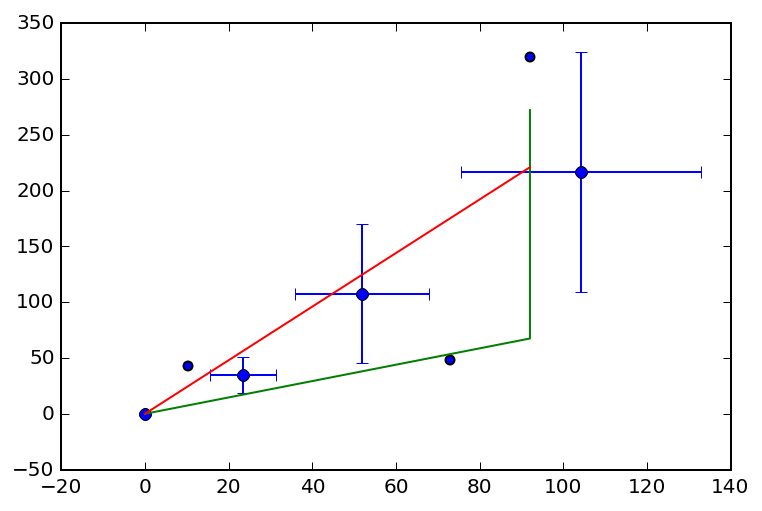

In [67]:
plt.scatter(xd, yd)
plt.errorbar(np.mean(age_arr, axis=0), np.mean(off_arr, axis=0),
             xerr=np.std(age_arr, axis=0), yerr=np.std(off_arr, axis=0),
             fmt='o')

plt.plot([0., breakpt, np.max(xd)],
         [0., m1 * breakpt, (m1 * breakpt) + ((np.max(xd) - breakpt) * m2)])

plt.plot([0., np.max(xd)], [0., m * np.max(xd)])

plt.show()


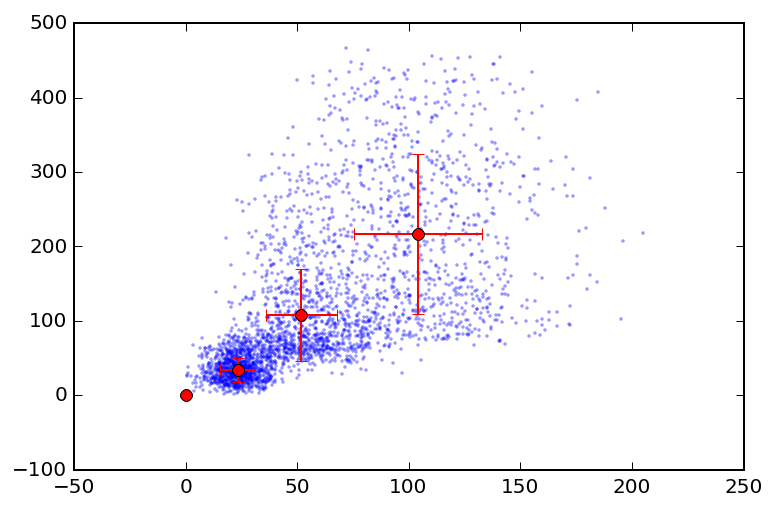

In [61]:
plt.scatter(age_arr.ravel(), off_arr.ravel(), lw=0, s=3, alpha=0.4)
plt.errorbar(np.mean(age_arr, axis=0), np.mean(off_arr, axis=0),
             xerr=np.std(age_arr, axis=0), yerr=np.std(off_arr, axis=0),
             fmt='o', c='r')
plt.show()

In [122]:
res_df = pd.DataFrame(index=np.arange(1000), columns=['m1', 'm2', 'breakpt', 'sumsq2', 'm', 'sumsq1'],
                     dtype='float')

In [123]:
for i in range(1000):
    xd = age_arr[i,:]
    yd = off_arr[i,:]
    
    res_df.ix[i, ['m1', 'm2', 'breakpt', 'sumsq2']]= piece_lin_opt(xd, yd)
    
    res_df.ix[i, ['m', 'sumsq1']] = lin_fit(xd, yd)
    

In [124]:
res_df.head()

,m1,m2,breakpt,sumsq2,m,sumsq1
0,1.953243,4.276652,73.365836,1.362439e+03,2.515762,3779.556571
1,6.210033,5.750648,43.850819,1.268498e+03,6.097179,1298.514095
2,1.219021,13.027203,57.255003,4.193540e-13,2.767166,3460.419796
3,1.739037,1.338779,43.121791,1.693234e+01,1.495721,198.531926
4,1.725306,0.415566,46.797153,1.250935e+03,1.049550,2358.872834


In [125]:
res_df.dtypes

m1         float64
m2         float64
breakpt    float64
sumsq2     float64
m          float64
sumsq1     float64
dtype: object

In [126]:
res_df['like1'] = log_like(res_df.sumsq1, 4)
res_df['like2'] = log_like(res_df.sumsq2, 4)

res_df['bic1'] = bic(res_df.like1, 4, 1)
res_df['bic2'] = bic(res_df.like1, 4, 3)

In [127]:
res_df.describe()

,m1,m2,breakpt,sumsq2,m,sumsq1,like1,like2,bic1,bic2
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,inf,3.299308e+06,51.540617,1.780068e+03,2.106350,5848.198386,-15.145238,-2.242679,-16.064177,-17.902054
std,NaN,9.326932e+07,23.286806,5.608614e+03,1.110716,9088.787691,3.381967,23.368274,3.381967,3.381967
min,-3.104332e-16,-4.763875e+00,0.000000,2.112611e-16,0.561203,1.759468,-22.092815,-22.062506,-23.011753,-24.849630
25%,1.238068e+00,6.874414e-01,36.740115,1.475287e+01,1.196469,708.437360,-17.521410,-13.863988,-18.440348,-20.278226
50%,1.858815e+00,1.821806e+00,52.952015,1.822507e+02,1.884345,2098.618495,-15.298069,-10.410765,-16.217008,-18.054885
75%,2.970580e+00,4.681719e+00,67.082974,1.024552e+03,2.788673,6378.716466,-13.126123,-5.382874,-14.045062,-15.882939
max,inf,2.942548e+09,122.093365,6.177494e+04,7.396370,62718.222297,-1.130023,72.186873,-2.048961,-3.886838


In [128]:
res_df[['bic1', 'bic2']].head()

,bic1,bic2
0,-17.393662,-19.231540
1,-15.256890,-17.094767
2,-17.217229,-19.055106
3,-11.500838,-13.338715
4,-16.450817,-18.288694


In [132]:
res_df[res_df.bic1 < res_df.bic2].count()

m1         0
m2         0
breakpt    0
sumsq2     0
m          0
sumsq1     0
like1      0
like2      0
bic1       0
bic2       0
dtype: int64